In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [3]:
#uncomment this decorator to test your code
@test 
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x = v*np.cos(curr_pose[2])*dt + curr_pose[0]
    y = v*np.sin(curr_pose[2])*dt + curr_pose[1]
    theta = curr_pose[2] + w*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
v = 1.0
w = 0.0
for _ in range(steps):
   #instruction to take v, w and compute new pose 
   straight_trajectory.append(pose)   
   new_pose = unicycle_model(pose, v, w)
   # store new pose
   pose = new_pose
straight_trajectory = np.array(straight_trajectory)
    

In [6]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values 
all_w = np.ones(steps*100)
all_v = 2*np.ones(steps*100)
for v,w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose 
    circle_trajectory.append(pose)      
    new_pose = unicycle_model(pose, v, w,1)
    # store new pose
    pose = new_pose
circle_trajectory = np.array(circle_trajectory)

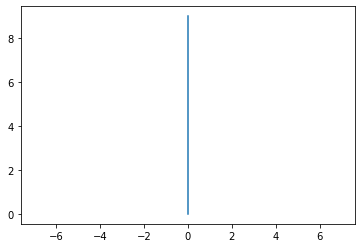

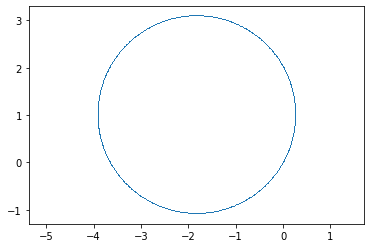

In [7]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1],',')



### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [8]:
v_c = 1 # m/s
w_c = np.pi/6 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
t_turn = int(np.pi/2*w_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/v_c)

all_w = [0]*t_straight1 + [w_c]*t_turn + [0]*t_straight2 + [-w_c]*t_turn + [0]*t_straight3 + [w_c]*t_turn
all_v = v_c*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [9]:
def get_open_loop_commands(route, vc, wc):
    all_w = []
    # print(len(route))
    omegas = {"straight":0, "right":-wc, "left":wc}
    for maneuver,value in route:
        u = omegas[maneuver]
        n = np.ceil(value)/vc if maneuver == "straight" else np.ceil(np.deg2rad(value))/wc
        n = n.astype(int)
        all_w += [u]*n
        # if maneuver == 'straight':
        #     all_w+= [0]*(np.ceil(route[idx][1]/vc).astype(int))
        # elif route[idx][0] == 'right':
        #     u = np.deg2rad(route[idx][1]/wc)
        #     all_w+= [-wc]*(np.ceil(u).astype(int))
        # elif route[idx][0] == 'left':
        #     u = np.deg2rad(route[idx][1]/wc)
        #     all_w+= [wc]*(np.ceil(u).astype(int))
    all_v = vc*np.ones_like(all_w)
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [10]:
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],1,np.pi/12)
print(len(all_w))

25


In [11]:
robot_trajectory = []
pose = (0, 0, np.pi/2)
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose)      
    new_pose = unicycle_model(pose, v, w)
   # store new pose
    pose = new_pose
robot_trajectory = np.array(robot_trajectory)
# print(robot_trajectory[0,:])
# print(robot_trajectory[-1,:])

25


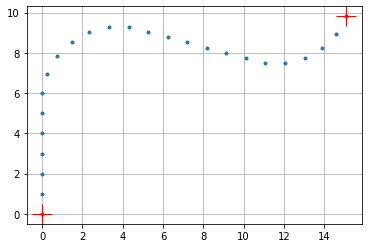

In [12]:
# plot robot trajectory
plt.figure()
plt.grid()
print(len(robot_trajectory))
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1],'.')

#show first and last robot positions with + markers
x0,y0,_ = robot_trajectory[0,:]
xf,yf,_ = robot_trajectory[-1,:]
# example: plt.plot(0, 0, 'r+', ms=10)
plt.plot(xf,yf,'r+',ms = 20)
plt.plot(x0,y0,'r+',ms = 20)


### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

In [13]:
def get_open_loop_commands_slow_turns(route, vcfast, vcslow, wc,dt = 1):
    all_w = []
    all_v = []
    deltas = {"straight":0, "left":wc, "right":-wc}
    for maneuver,value in route:
        u = deltas[maneuver]
        angle_steps = np.ceil(np.deg2rad(value)/(wc*dt))
        all_w += [u]*np.ceil(value/(vcfast*dt)).astype(int) if maneuver == "straight" else [u]*angle_steps.astype(int)
        all_v += [vcfast]*np.ceil(value/(vcfast*dt)).astype(int) if maneuver == "straight" else [vcslow]*angle_steps.astype(int)
    return all_v, all_w

85


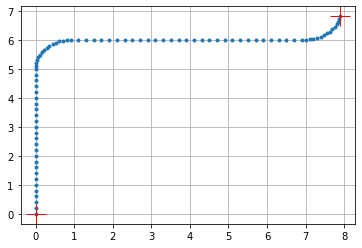

In [14]:
vcfast = 1
vcslow = 0.5
dt = 0.2
all_v, all_w = get_open_loop_commands_slow_turns([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],vcfast,vcslow,np.pi/6,dt)
# print(len(all_w))
robot_trajectory = []
pose = (0, 0, np.pi/2)
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose)      
    new_pose = unicycle_model(pose, v, w,dt)
   # store new pose
    pose = new_pose
robot_trajectory = np.array(robot_trajectory)
# plot robot trajectory
plt.figure()
plt.grid()
print(len(robot_trajectory))
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1],'.')

#show first and last robot positions with + markers
x0,y0,_ = robot_trajectory[0,:]
xf,yf,_ = robot_trajectory[-1,:]
# example: plt.plot(0, 0, 'r+', ms=10)
plt.plot(xf,yf,'r+',ms = 20)
plt.plot(x0,y0,'r+',ms = 20)